In [1]:
import numpy as np
import matplotlib.pyplot as plt
import collections
import datetime

# Process UWB Data from CSV

In [2]:
gps_data = {
    'latitude': [],
    'longitude': [],
    'speed': [],
    'altitude': [],
    'numSats': []
}
imu_data = {
    'timeMillis': [],
    'xAccel': [],
    'yAccel': [],
    'zAccel': [],
    'xGyro': [],
    'yGyro': [],
    'zGyro': [],
    'xMag': [],
    'yMag': [],
    'zMag': [],
    'temp': []
}

num_adcs = 1016
uwb_data = {
    'timeMs': [],
    'timeEpoch': [],
    'real' : [ [] for i in range(num_adcs) ],
    'imaginary' : [ [] for i in range(num_adcs) ]
}

timeRelation = {
    'epoch': None,
    'millis': None,
    'clockSlowdown': 1
}

In [3]:
# for now, make sure the imu data is strictly increasing to capture data for one trial
prev_time = 0

with open('data/output_11_9.txt', 'r') as file:
    for line in file:
        if line.startswith('GPS'):
            _, lat, lon, speed, altitude, numSats = line[5:].split(',')
            gps_data['latitude'].append(float(lat))
            gps_data['longitude'].append(float(lon))
            gps_data['speed'].append(float(speed))
            gps_data['altitude'].append(float(altitude))
            gps_data['numSats'].append(int(numSats))
        elif line.startswith('Time:'):
            #remove erroneous text
            line = line.replace('Time: ', '')
            line = line.replace('millis:', '')

            #first 5 chars are date
            date = line[0:5]
            timestamp, millis = line[6:].split(',')

            #remove spaces
            date.replace(' ', '')
            timestamp.replace(' ', '')
            millis.replace(' ', '')

            #convert to epoch timestamp
            humanTime = date + ' ' + timestamp + ' ' + '+0000'

            #format is 'MM-DD HH:MM:SS.SSS'
            epochTime = datetime.datetime.strptime(humanTime, '%m-%d %H:%M:%S.%f %z')
            epochTime = epochTime.replace(year=2023)
            epochTime = epochTime.timestamp()

            #store time relation
            timeRelation['epoch'] = epochTime
            timeRelation['millis'] = int(millis)

        elif line.startswith('CIR'):
            #this is the "UWB Accumulator" register with waveform data
            line = line.split(' ')
            acc_mem = line[3] #CIR num1 num2 acc_mem
            acc_mem = acc_mem.split('],[')
            #remove initial semicolon
            acc_mem[0] = acc_mem[0][1:]

            #extract time
            timeMs = acc_mem[0].split(',')[0]
            #remove time from acc_mem
            acc_mem[0] = acc_mem[0][len(timeMs)+1:]

            acc_mem[-1] = acc_mem[-1][:-3] #lines end in '...,]\n' so remove the last 3 chars

            #ensure good data
            assert len(acc_mem) == num_adcs

            #split into real and imaginary parts
            uwb_data['timeMs'].append(int(timeMs))
            for i in range(num_adcs):
                memVals = acc_mem[i].split(',')
                if len(memVals) != 4:
                    print('bad data: ' + acc_mem[i])
                    continue #bad data
                
                value, real, imaginary, adc = acc_mem[i].split(',')
                uwb_data['real'][i].append(int(real))
                uwb_data['imaginary'][i].append(int(imaginary))
        else: # line.startswith('UWB') and not line.startswith('.'):
            params = line.split(',')
            if len(params) > 11:
                params = params[0:11]
            elif len(params) < 11:
                print('bad line: ' + line)
                continue
            time, x_accel, y_accel, z_accel, x_gyro, y_gyro, z_gyro, x_mag, y_mag, z_mag, temp = params
            if int(time) < prev_time:
                valid = False
                continue
            imu_data['timeMillis'].append(int(time))
            imu_data['xAccel'].append(float(x_accel))
            imu_data['yAccel'].append(float(y_accel))
            imu_data['zAccel'].append(float(z_accel))
            imu_data['xGyro'].append(float(x_gyro))
            imu_data['yGyro'].append(float(y_gyro))
            imu_data['zGyro'].append(float(z_gyro))
            imu_data['xMag'].append(float(x_mag))
            imu_data['yMag'].append(float(y_mag))
            imu_data['zMag'].append(float(z_mag))
            imu_data['temp'].append(float(temp))
            prev_time = int(time)
            

num_sats_counts = collections.Counter(gps_data['numSats'])
num_sats_values = list(num_sats_counts.keys())
num_sats_count = list(num_sats_counts.values())  

#clock slowdown is based on difference in recording time between GT and UWB
timeRelation['clockSlowdown'] = 1 #(uwb_data['timeMs'][-1] - uwb_data['timeMs'][0]) / (imu_data['timeMillis'][-1] - imu_data['timeMillis'][0])

print('clock slowdown: ' + str(timeRelation['clockSlowdown']))

#create epoch timestamp for UWB ata
uwb_data['timeEpoch'] = [ timeRelation['epoch'] + ((time - timeRelation['millis'])/1000) / timeRelation['clockSlowdown'] for time in uwb_data['timeMs'] ]

clock slowdown: 1


# Process Ground Truth Data from CSV

In [4]:
ground_truth = {
    'epoch_time' : [],
    'num_people' : []
}

with open('data/ground_truth.csv', 'r') as file:
    for line in file:
        time, num_people = line.split(',')
        ground_truth['epoch_time'].append(float(time))
        ground_truth['num_people'].append(int(num_people))

In [5]:
#delete data where ground truth or data point is missing

first_gt = ground_truth['epoch_time'][0]
last_gt = ground_truth['epoch_time'][-1]

first_uwb = uwb_data['timeEpoch'][0]
last_uwb = uwb_data['timeEpoch'][-1]

first_time = max(first_gt, first_uwb)
last_time = min(last_gt, last_uwb)

#find first index
first_gt_index = 0
while ground_truth['epoch_time'][first_gt_index] < first_time:
    first_gt_index += 1

first_uwb_index = 0
while uwb_data['timeEpoch'][first_uwb_index] < first_time:
    first_uwb_index += 1

#find last index
last_gt_index = len(ground_truth['epoch_time']) - 1
while ground_truth['epoch_time'][last_gt_index] > last_time:
    last_gt_index -= 1

last_uwb_index = len(uwb_data['timeEpoch']) - 1
while uwb_data['timeEpoch'][last_uwb_index] > last_time:
    last_uwb_index -= 1

#delete data
ground_truth['epoch_time'] = ground_truth['epoch_time'][first_gt_index:last_gt_index]
ground_truth['num_people'] = ground_truth['num_people'][first_gt_index:last_gt_index]

uwb_data['timeEpoch'] = uwb_data['timeEpoch'][first_uwb_index:last_uwb_index]
uwb_data['real'] = [ data[first_uwb_index:last_uwb_index] for data in uwb_data['real'] ]
uwb_data['imaginary'] = [ data[first_uwb_index:last_uwb_index] for data in uwb_data['imaginary'] ]

# Data Visualization

In [6]:
#linearly interpolate ground truth data to match UWB data
ground_truth['num_people'] = np.interp(uwb_data['timeEpoch'], ground_truth['epoch_time'], ground_truth['num_people'])
ground_truth['epoch_time'] = uwb_data['timeEpoch']

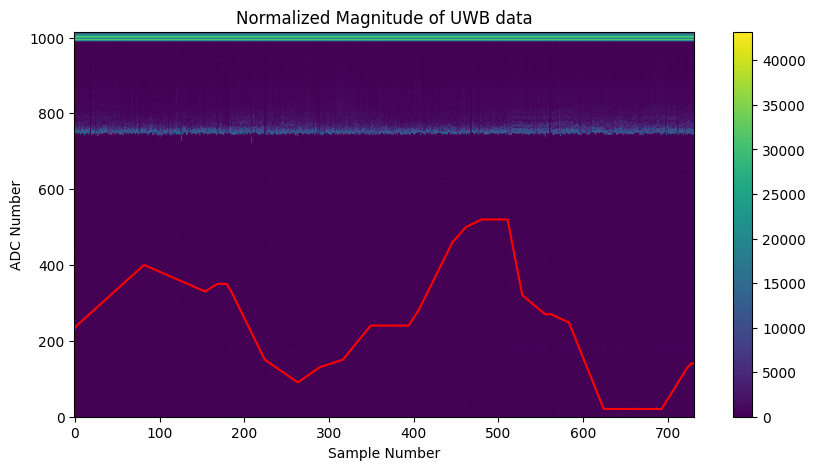

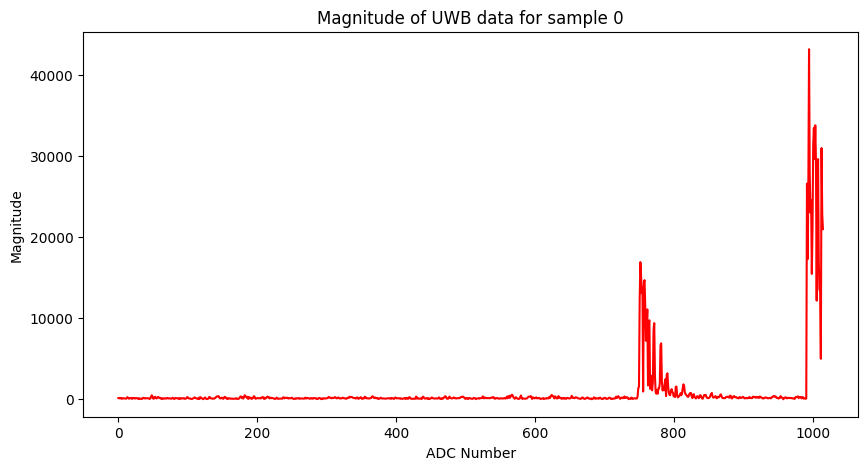

In [7]:
#show a spectrogram of the UWB data

#convert to numpy arrays
import numpy as np
real = np.array(uwb_data['real'], dtype=np.float64)
imaginary = np.array(uwb_data['imaginary'], dtype=np.float64)

#convert to complex numbers
complex_data = real + imaginary*1j

#compute the magnitude
magnitude = np.abs(complex_data)

normalize = False
if normalize:
    for i in range(num_adcs): #Normalize data for each ADC
        magnitude[i,:] = magnitude[i,:] / np.max(magnitude[i,:])

#compute the phase
phase = np.angle(complex_data)

#plot the magnitude
plt.figure(figsize=(10, 5))
plt.imshow(magnitude, aspect='auto')

#draw ground truth on top
plt.plot(ground_truth['num_people'] * 10, color='red', label='ground truth')

#invert y axis
plt.gca().invert_yaxis()

plt.colorbar()
plt.title('Normalized Magnitude of UWB data')
plt.xlabel('Sample Number')
plt.ylabel('ADC Number')
plt.show()

plt.figure(figsize=(10, 5))
adcNum = 800
plt.plot(magnitude[:, 0], color='red', label='ground truth')
plt.title('Magnitude of UWB data for sample 0')
plt.xlabel('ADC Number')
plt.ylabel('Magnitude')
plt.show()



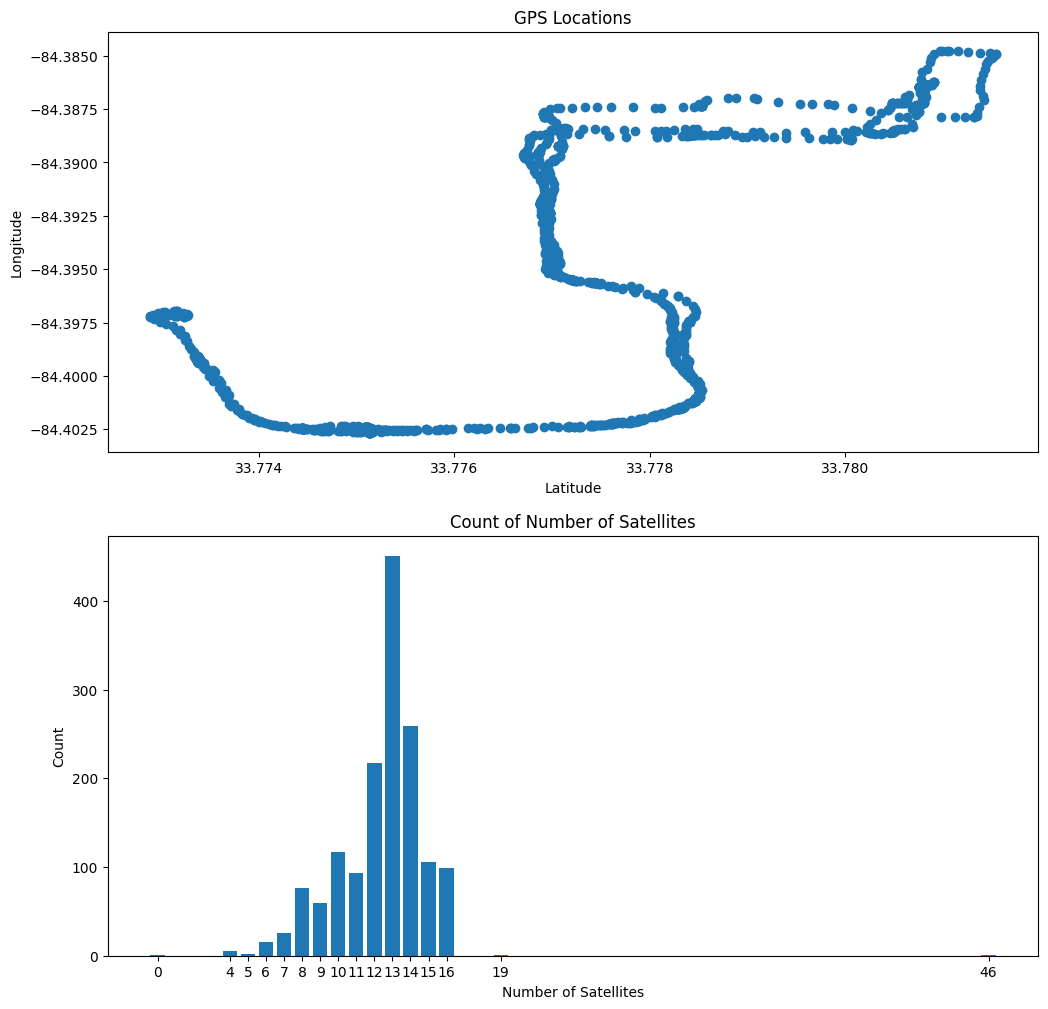

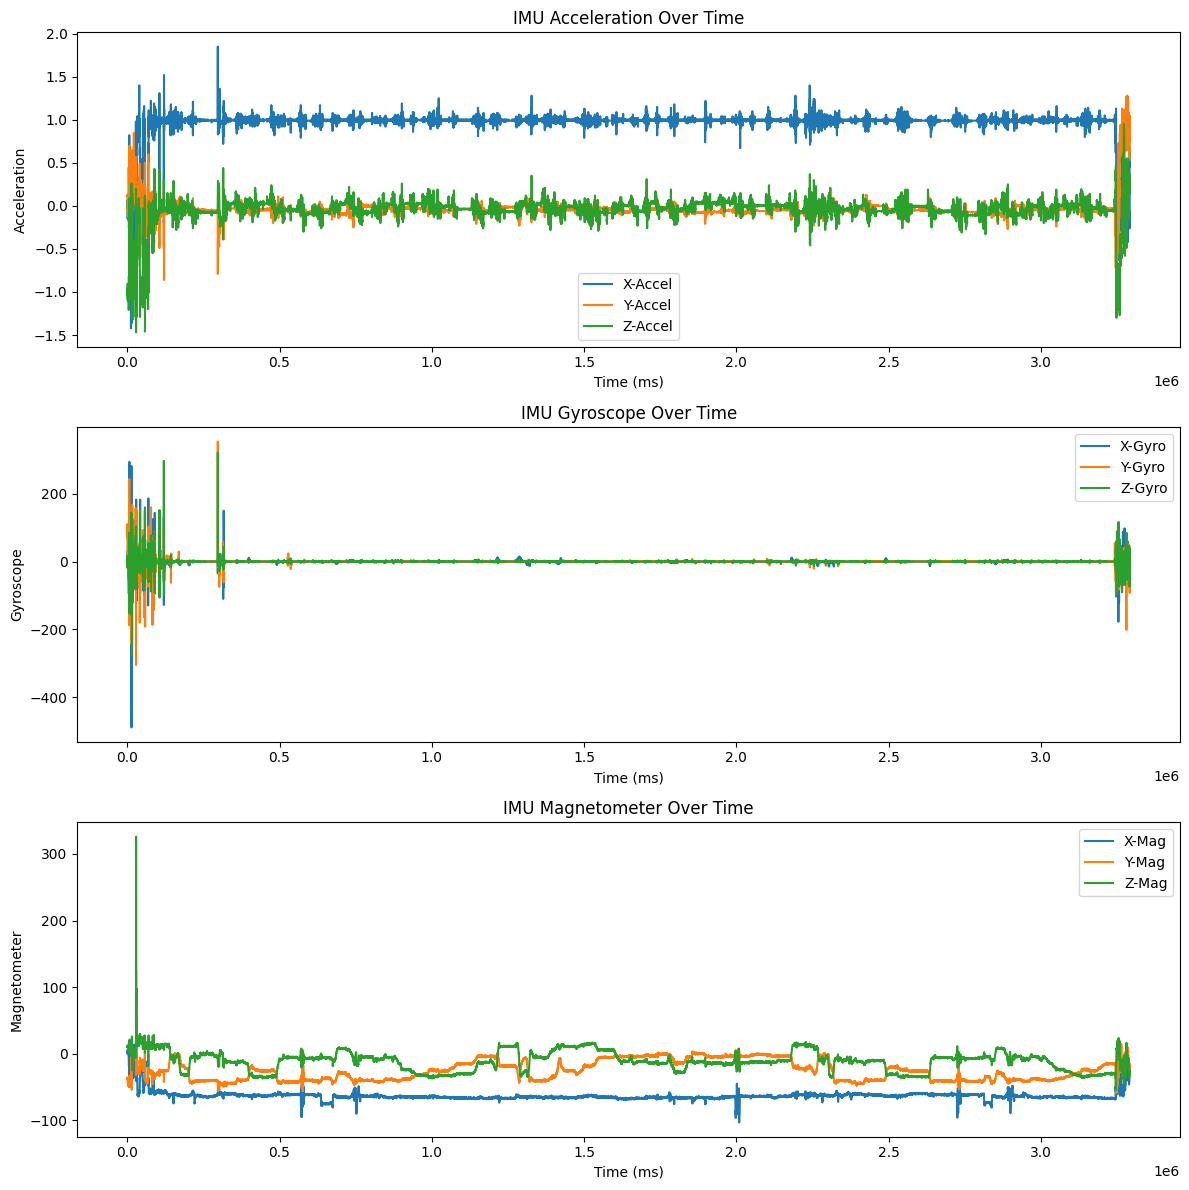

In [8]:
plt.figure(figsize=(12, 12))

# Latitude vs Longitude
plt.subplot(2, 1, 1)
plt.scatter(gps_data['latitude'], gps_data['longitude'])
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('GPS Locations')

# Number of Satellites vs Count
plt.subplot(2, 1, 2)
plt.bar(num_sats_values, num_sats_count)
plt.xlabel('Number of Satellites')
plt.ylabel('Count')
plt.title('Count of Number of Satellites')
plt.xticks(num_sats_values)
plt.show()

plt.figure(figsize=(12, 12))

# Acceleration over Time
plt.subplot(3, 1, 1)
plt.plot(imu_data['timeMillis'], imu_data['xAccel'], label='X-Accel')
plt.plot(imu_data['timeMillis'], imu_data['yAccel'], label='Y-Accel')
plt.plot(imu_data['timeMillis'], imu_data['zAccel'], label='Z-Accel')
plt.xlabel('Time (ms)')
plt.ylabel('Acceleration')
plt.title('IMU Acceleration Over Time')
plt.legend()

# Gyroscope over Time
plt.subplot(3, 1, 2)
plt.plot(imu_data['timeMillis'], imu_data['xGyro'], label='X-Gyro')
plt.plot(imu_data['timeMillis'], imu_data['yGyro'], label='Y-Gyro')
plt.plot(imu_data['timeMillis'], imu_data['zGyro'], label='Z-Gyro')
plt.xlabel('Time (ms)')
plt.ylabel('Gyroscope')
plt.title('IMU Gyroscope Over Time')
plt.legend()

# Magnetometer over Time
plt.subplot(3, 1, 3)
plt.plot(imu_data['timeMillis'], imu_data['xMag'], label='X-Mag')
plt.plot(imu_data['timeMillis'], imu_data['yMag'], label='Y-Mag')
plt.plot(imu_data['timeMillis'], imu_data['zMag'], label='Z-Mag')
plt.xlabel('Time (ms)')
plt.ylabel('Magnetometer')
plt.title('IMU Magnetometer Over Time')
plt.legend()

plt.tight_layout()
plt.show()

# Data Analysis

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.decomposition import PCA

In [10]:
#linear classifier for number of people vs UWB data

#reshape data
magnitude = magnitude[720:850, :]
print(magnitude.shape)
X = magnitude.T

y_num = ground_truth['num_people']

#find quantiles
quantiles = np.quantile(y_num, [0.25, 0.5, 0.75])
print(quantiles)
#group data into 4 classes
y = np.digitize(y_num, quantiles)

(130, 732)
[13.48345756 25.68222758 35.        ]


In [17]:
#get first index that exceeds 5000
for i in range(magnitude.shape[1]):
    first_index = 0
    while magnitude[first_index, i] < 10000 and first_index < magnitude.shape[0] - 1:
        first_index += 1
    
    #move range such that first index is at 20
    magnitude[:, i] = np.roll(magnitude[:, i], 20 - first_index)
    

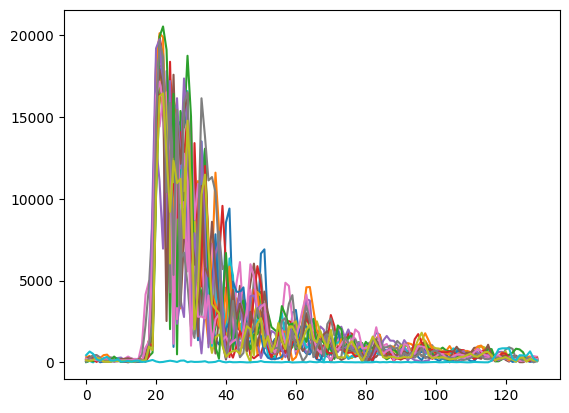

In [18]:
plt.figure()
timestep = 10
for i in range(20):
    plt.plot(magnitude[:, i])
# plt.plot(magnitude[:, timestep], label='ground truth')
plt.show()

In [19]:
#use a Gaussian Process Classifier to classify the data
from sklearn.gaussian_process import GaussianProcessClassifier

#split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#train the classifier
clf = GaussianProcessClassifier()
clf.fit(X_train, y_train)

#test the classifier
print('Gaussian Process Classifier')
print('Training accuracy: ' + str(clf.score(X_train, y_train)))
print('Testing accuracy: ' + str(clf.score(X_test, y_test)))


Gaussian Process Classifier
Training accuracy: 1.0
Testing accuracy: 0.24489795918367346


In [20]:
def make_confusion(y_true, y_pred):
    #make a confusion matrix
    confusion = np.zeros((4,4))
    for i in range(len(y_true)):
        confusion[y_true[i], y_pred[i]] += 1

    plt.figure(figsize=(10,10))
    plt.imshow(confusion, cmap='gray')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    #draw percentages
    for i in range(4):
        for j in range(4):
            plt.text(j, i, str(round(confusion[i,j]/np.sum(confusion[i,:]), 2)), ha='center', va='center')
    plt.xticks([0,1,2,3])
    plt.yticks([0,1,2,3])

/Users/nathanmalta/miniconda3/envs/eyeTracking/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Classifier
Training accuracy: 0.9965811965811966
Testing accuracy: 0.41496598639455784
Random Forest Classifier
Training accuracy: 1.0
Testing accuracy: 0.5986394557823129


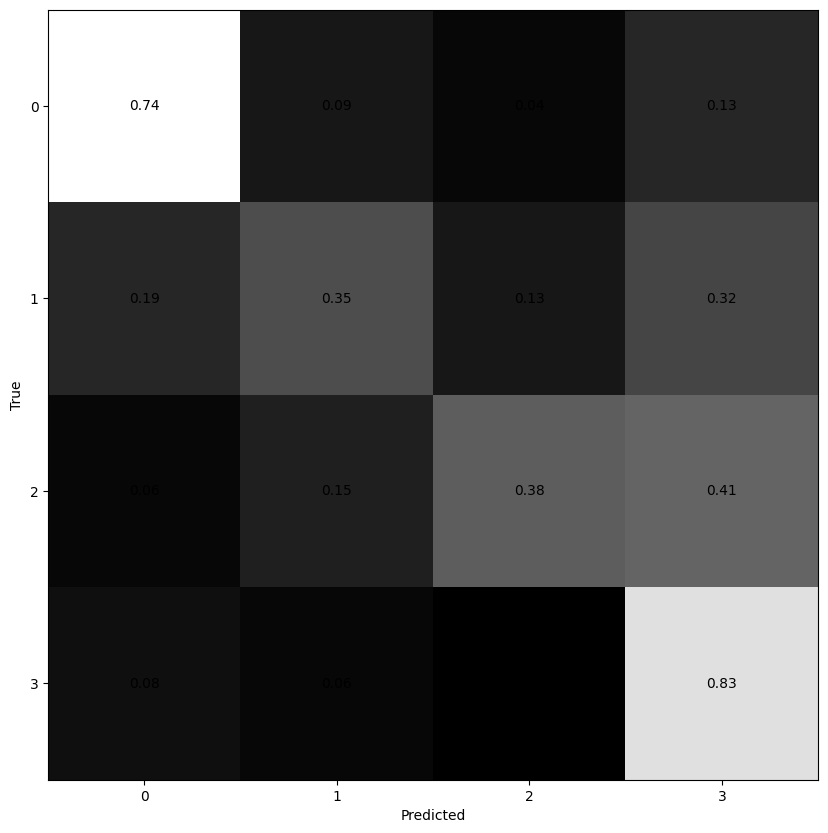

In [22]:
#try a Linear Classifier
from sklearn.linear_model import LogisticRegression

#train the classifier
clf = LogisticRegression(max_iter=20000)
clf.fit(X_train, y_train)

#test the classifier
print('Logistic Regression Classifier')
print('Training accuracy: ' + str(clf.score(X_train, y_train)))
print('Testing accuracy: ' + str(clf.score(X_test, y_test)))

#try a random forest
from sklearn.ensemble import RandomForestClassifier

#train the classifier
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train)

#test the classifier
print('Random Forest Classifier')
print('Training accuracy: ' + str(clf.score(X_train, y_train)))
print('Testing accuracy: ' + str(clf.score(X_test, y_test)))
make_confusion(y_test, clf.predict(X_test))

In [16]:
#try a gradient boosting classifier
from sklearn.ensemble import GradientBoostingClassifier

#train the classifier
clf = GradientBoostingClassifier(n_estimators=50)
clf.fit(X_train, y_train)

#test the classifier
print('Gradient Boosting Classifier')
print('Training accuracy: ' + str(clf.score(X_train, y_train)))
print('Testing accuracy: ' + str(clf.score(X_test, y_test)))

Gradient Boosting Classifier
Training accuracy: 1.0
Testing accuracy: 0.5374149659863946
